<a href="https://colab.research.google.com/github/CarlViggo/Carl-Viggo---Rays-2023/blob/main/Tumor_Classification_Rays_2023_Carl-Viggo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project Pipeline
The following code classifies images of lung tumors from the Kaggle Data Science Bowl 2017 data set.

**Part 1** \\
Random Forests, Decision Tree and K-Nearest Neighbors are initially compared to one another. The best model is chosen and evaluated furter.

**Part 2** \\
Three different convoluitional neural network architectures, of increasing complexity, are compared to one another, LeNet, AlexNet and VGG16 with transfer learning.

/Carl Viggo Nilsson Gravenhorst-Lövenstierne

**The following definitions are used in the code**
\
\
1 - Malignant \\
0 - Benign
\
\
Class1 - benign \\
Class2 - malignant
\
\
Train size = 907 \\
Validation size = 390

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/Rays/Projects/" /gdrive

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
from random import shuffle
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.transform import resize

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Convolution2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from tensorflow.keras import applications
from keras.layers import GlobalAveragePooling2D


In [ ]:
#Matches the file name with its corresponding class
def gen_labels(im_name, data_path, pat1, pat2):
    '''

    Parameters
    ----------
    im_name : Str
        The image file name.

    Returns
    -------
    Label : Numpy array
        Class label of the filename name based on its pattern.
    '''
    if "C1" in data_path:
        label = np.array([0])
    elif "C2" in data_path:
        label = np.array([1])
    return label

#Creates a nested list with the following structure: [(file_name, label), ...]
def get_data(data_path, data_list, img_h, img_w):
    """

    Parameters
    ----------
    train_data_path : Str
        Path to the data directory
    train_list : List
        A list containing the name of the images.
    img_h : Int
        image height to be resized to.
    img_w : Int
        image width to be resized to.
    """
    img_labels = []
    for item in enumerate(data_list):
        img = imread(os.path.join(data_path, item[1]), as_gray = False) # "as_grey"
        #img = cv2.imread(os.path.join(data_path, item[1]))
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        img_labels.append([np.array(img), gen_labels(item[1], data_path,  'AFF', 'NFF')])

        if item[0] % 100 == 0:
             print('Reading: {0}/{1}  of train images'.format(item[0], len(data_list)))

    #Shuffles the list for generalization purposes
    shuffle(img_labels)
    return img_labels

#Unfolds the images and converts them to compatible arrays.
def get_data_arrays(nested_list, img_h, img_w):
    """
    Parameters
    ----------
    nested_list : nested list
        nested list of image arrays with corresponding class labels.
    img_h : Int
        Image height.
    img_w : Int
        Image width.

    Returns
    -------
    img_arrays : Numpy array
        4D Array with the size of (n_data,img_h,img_w, 1)
    label_arrays : Numpy array
        1D array with the size (n_data).

    """
    img_arrays = np.zeros((len(nested_list), img_h, img_w), dtype = np.float32)
    label_arrays = np.zeros((len(nested_list)), dtype = np.int32)
    for ind in range(len(nested_list)):
        img_arrays[ind] = nested_list[ind][0]
        label_arrays[ind] = nested_list[ind][1]
    img_arrays = np.expand_dims(img_arrays, axis =3)
    return img_arrays, label_arrays

#Returns the training and the testing data
def get_train_test_arrays(train_data_path, test_data_path, train_list,
                          test_list, img_h, img_w):

    """
    Get the directory to the train and test sets, the files names and
    the size of the image and return the image and label arrays for
    train and test sets.
    """

    train_data = get_data(train_data_path, train_list, img_h, img_w)
    test_data = get_data(test_data_path, test_list, img_h, img_w)

    train_img, train_label =  get_data_arrays(train_data, img_h, img_w)
    test_img, test_label = get_data_arrays(test_data, img_h, img_w)
    del(train_data)
    del(test_data)
    return train_img, test_img, train_label, test_label

In [ ]:
#Define input arguments for get_train_test_arrays

c1_train_data_path = "/gdrive/Data/Lung_2D/images/class1/C1_train/"
c1_test_data_path = "/gdrive/Data/Lung_2D/images/class1/C1_test/"

c2_train_data_path = "/gdrive/Data/Lung_2D/images/class2/C2_train/"
c2_test_data_path = "/gdrive/Data/Lung_2D/images/class2/C2_test/"

#Creates lists containing the file names for the different classes
c1_train_list = os.listdir(c1_train_data_path)
c1_val_list = os.listdir(c1_test_data_path)

c2_train_list = os.listdir(c2_train_data_path)
c2_val_list = os.listdir(c2_test_data_path)

In [ ]:
#Defines the image dimensions
img_h = 224
img_w = 224

In [ ]:
#Retrieves training and testing data for C1 class (benign)
c1_x_train, c1_x_test, c1_y_train, c1_y_test = get_train_test_arrays(c1_train_data_path, c1_test_data_path, c1_train_list, c1_val_list, img_h, img_w)


Reading: 0/614  of train images
Reading: 100/614  of train images
Reading: 200/614  of train images
Reading: 300/614  of train images
Reading: 400/614  of train images
Reading: 500/614  of train images
Reading: 600/614  of train images
Reading: 0/254  of train images
Reading: 100/254  of train images
Reading: 200/254  of train images


In [ ]:
#Retrieves training and testing data for C2 class (malignant)
c2_x_train, c2_x_test, c2_y_train, c2_y_test = get_train_test_arrays(
        c2_train_data_path, c2_test_data_path,
        c2_train_list, c2_val_list, img_h, img_w)

Reading: 0/293  of train images
Reading: 100/293  of train images
Reading: 200/293  of train images
Reading: 0/120  of train images
Reading: 100/120  of train images


In [ ]:
#Combines the C1 and the C2 testing and training data to create the final training and testing data
x_train = np.concatenate((c1_x_train, c2_x_train))
y_train = np.concatenate((c1_y_train, c2_y_train))
x_val = np.concatenate((c1_x_test, c2_x_test))
y_val = np.concatenate((c1_y_test, c2_y_test))

x_train.shape

(907, 224, 224, 1)

#Vizualization

1


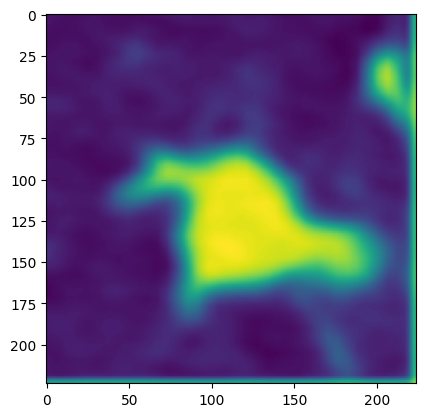

In [ ]:
#Verify matching between image and label.
plt.imshow(x_train[800])
print(y_train[800])

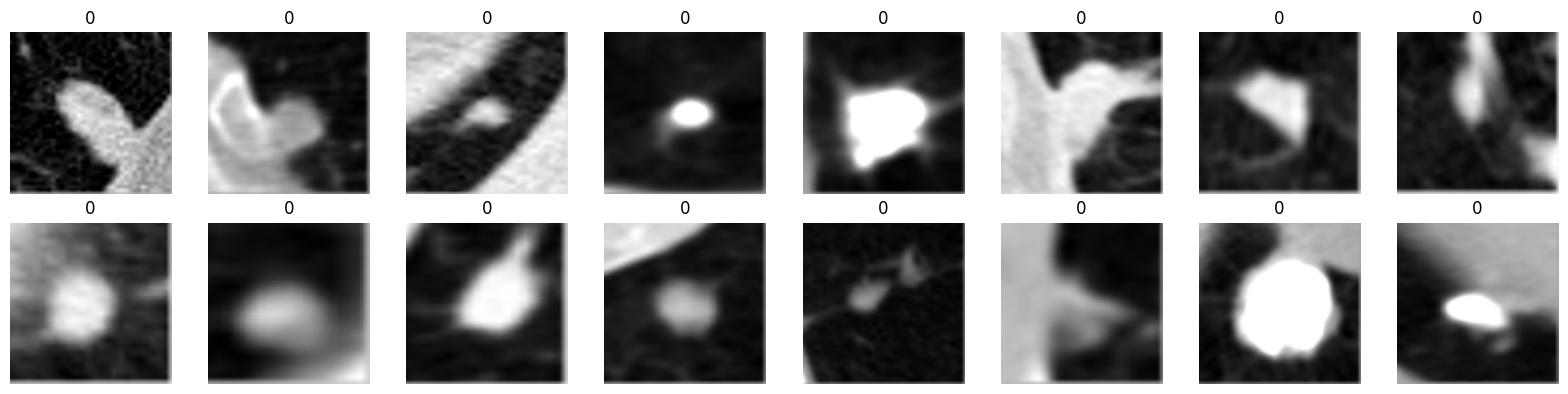

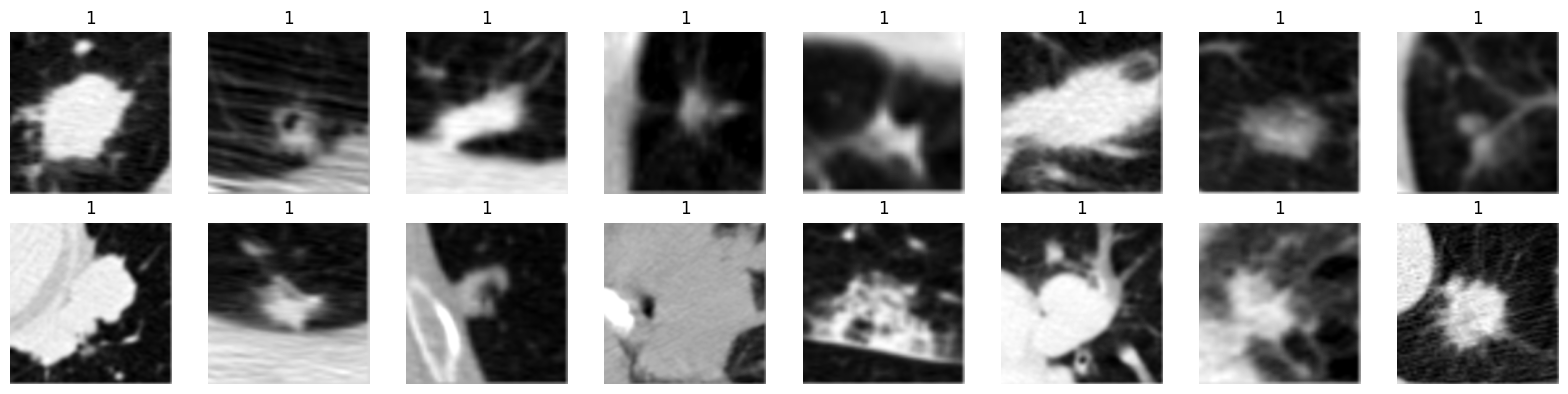

In [ ]:
#For vizualisation purposes. Vizualizez a selection of images from the both classes and their corresponding labels

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 8, figsize=(16, 4))

# Array of titles
titles = y_train

# Iterate over each subplot and title
for i in range(2):
    for j in range(8):
        # Load and display the images
        axs[i, j].imshow(x_train[i*8 + j], cmap='gray')
        axs[i, j].set_title(titles[i*8 + j])
        axs[i, j].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

fig2, axs2 = plt.subplots(2, 8, figsize=(16, 4))

# Starting index
start_index = 890

# Repeat for second class
for k in range(2):
    for h in range(8):
        index = start_index + k*8 + h

        axs2[k, h].imshow(x_train[index], cmap='gray')

        axs2[k, h].set_title(y_train[index])

        axs2[k, h].axis('off')

plt.tight_layout()

plt.show()

#Plotting Function

#Model Architectures

In [ ]:
#Generates two subplots of learning curves
def plotting(model_name, directory_path, save, from_val, from_acc):

  model_std_loss = np.std(model_name.history["val_loss"][from_val:])
  model_mean_loss = np.mean(model_name.history["val_loss"][from_val:])
  model_boundary_high_loss = model_mean_loss + model_std_loss
  model_boundary_low_loss = model_mean_loss - model_std_loss

  model_std_acc = np.std(model_name.history["val_binary_accuracy"][from_acc:])
  model_mean_acc = np.mean(model_name.history["val_binary_accuracy"][from_acc:])
  model_boundary_high_acc = model_mean_acc + model_std_acc
  model_boundary_low_acc = model_mean_acc - model_std_acc

  fig, axes = plt.subplots(1, 2, figsize=(10, 4))

  # Plot Loss Value
  axes[1].axhline(model_mean_loss, color='red', linestyle='--', label='mean val loss')
  axes[1].axhline(model_boundary_high_loss, color='green', linestyle='--', label='decision boundary (+std_dev)')
  axes[1].axhline(model_boundary_low_loss, color='blue', linestyle='--', label='decision boundary (-std_dev)')


  axes[1].plot(model_name.history["loss"], label="loss")
  axes[1].plot(model_name.history["val_loss"], label="val loss")
  axes[1].plot(np.argmin(model_name.history["val_loss"]),
              np.min(model_name.history["val_loss"]),
              marker="x", color="r", label="best model")
  axes[1].set_xlabel("Epochs")
  axes[1].set_ylabel("Loss Value")
  axes[1].legend(frameon=False)

  # Plot Validation Accuracy
  axes[0].axhline(model_mean_acc, color='red', linestyle='--', label='mean val accuracy')
  axes[0].axhline(model_boundary_high_acc, color='green', linestyle='--', label='decision boundary (+std_dev)')
  axes[0].axhline(model_boundary_low_acc, color='blue', linestyle='--', label='decision boundary (-std_dev)')
  axes[0].plot(model_name.history["binary_accuracy"], label="accuracy")
  axes[0].plot(model_name.history["val_binary_accuracy"], label="val accuracy")
  axes[0].plot(np.argmax(model_name.history["val_binary_accuracy"]),
          np.max(model_name.history["val_binary_accuracy"]),
          marker="x", color="r", label="best model")
  axes[0].set_xlabel("Epochs")
  axes[0].set_ylabel("Accuracy")
  axes[0].legend(loc="lower right", frameon=False)

  plt.tight_layout()
  if save == True:
    plt.savefig(directory_path, dpi=300)

  plt.show()
  print(model_std_loss)
  print(model_std_acc)
  print(model_mean_loss)
  print(model_mean_acc)
  return

In [ ]:
#LeNet Architecture
def LeNet(img_ch, img_width, img_height):
    model = Sequential()
    model.add(Conv2D(n_base, kernel_size = (3, 3), activation='relu',
                     strides=1, padding='same',
                     input_shape = (img_width, img_height, img_ch))) #base determines the number of filters that should be applied.
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(n_base*2, kernel_size = (3, 3), activation='relu',
                     strides=1, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten()) #Flatten before entering the dense layer.
    model.add(Dense(n_base*2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    return model

In [ ]:
# AlexNet Architecture
def AlexNet(img_ch, img_width, img_height):

    model = Sequential()

    model.add(Conv2D(filters=n_base, input_shape=(img_width, img_height, img_ch),
                     kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=n_base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=n_base*4, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=n_base*2, kernel_size=(3,3), strides=(1,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.summary()
    return model

In [ ]:
#VGG16 Architecture
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))
    model.summary()
    return model

---

In [ ]:
#Verify shapes
print(x_train.shape)
print(x_train[0].shape)

(907, 224, 224, 1)
(224, 224, 1)


In [ ]:
#Define hyperparameters
img_ch, img_width, img_height = 1, 224, 224
n_epochs = 50
batch_s = 3
n_base = 4
learn_rate = 1e-5

In [ ]:
#For the VGG16 model, the shape must be (244,244,3). The current shape is (244,244,1). The following code stacks three identical images on top of another to fulfill the criteria.
x_trainRGB = np.array([np.concatenate([gray_image] * 3, axis=2) for gray_image in x_train])
x_valRGB = np.array([np.concatenate([gray_image] * 3, axis=2) for gray_image in x_val])

In [ ]:
#Instantiates the pre-trained VGG16 network
VGG16 = applications.VGG16(include_top=False, weights='imagenet')

#Makes sure the model won't be trained
for layer in VGG16.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#Generates feature maps from the VGG16 model
x_train_predict = VGG16.predict(x_trainRGB)
x_val_predict = VGG16.predict(x_valRGB)

12/12 [==============================] - 233s 19s/step


In [ ]:
#Defines the trainable neural network connected to the pre-trained VGG16 model
model_1 = Sequential()
model_1.add(Flatten(input_shape=x_train_predict.shape[1:]))
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='sigmoid'))
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                8224      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

In [ ]:
model_1.compile(optimizer=Adam(learning_rate = learn_rate),loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#Fit the neural network added on top of the VGG16 model
VGG16 = model_1.fit(x_train_predict, y_train,
          epochs=n_epochs,
          batch_size=batch_s,
          validation_data=(x_val_predict, y_val))

Epoch 1/50
303/303 [==============================] - 58s 190ms/step - loss: 0.6957 - accuracy: 0.5711 - val_loss: 0.6293 - val_accuracy: 0.6791
Epoch 2/50
303/303 [==============================] - 59s 194ms/step - loss: 0.6608 - accuracy: 0.6185 - val_loss: 0.5994 - val_accuracy: 0.6791
Epoch 3/50
303/303 [==============================] - 59s 196ms/step - loss: 0.6319 - accuracy: 0.6648 - val_loss: 0.5950 - val_accuracy: 0.6791
Epoch 4/50
303/303 [==============================] - 59s 193ms/step - loss: 0.6585 - accuracy: 0.6284 - val_loss: 0.5891 - val_accuracy: 0.6791
Epoch 5/50
303/303 [==============================] - 59s 194ms/step - loss: 0.6402 - accuracy: 0.6494 - val_loss: 0.5980 - val_accuracy: 0.6898
Epoch 6/50
303/303 [==============================] - 57s 189ms/step - loss: 0.6337 - accuracy: 0.6284 - val_loss: 0.5791 - val_accuracy: 0.7059
Epoch 7/50
303/303 [==============================] - 57s 190ms/step - loss: 0.6126 - accuracy: 0.6803 - val_loss: 0.5738 - val_ac

In [ ]:
model_file_path = '/content/drive/My Drive/Rays/Projects/Saved_Models/VGG16.h5'

# Save the model
model_1.save(model_file_path)

In [ ]:
#statistics.
VGG16_std_loss = np.std(VGG16.history["val_loss"][15:])
VGG16_mean_loss = np.mean(VGG16.history["val_loss"][15:])
VGG16_boundary_high_loss = VGG16_mean_loss + VGG16_std_loss
VGG16_boundary_low_loss = VGG16_mean_loss - VGG16_std_loss

VGG16_std_acc = np.std(VGG16.history["accuracy"][15:])
VGG16_mean_acc = np.mean(VGG16.history["accuracy"][15:])
VGG16_boundary_high_acc = VGG16_mean_acc + VGG16_std_acc
VGG16_boundary_low_acc = VGG16_mean_acc - VGG16_std_acc

print(VGG16_std_loss)
print(VGG16_std_acc)
print(VGG16_mean_loss)
print(VGG16_mean_acc)

0.009736179081823258
0.024620301944975588
0.5298611760139466
0.7517404351915632


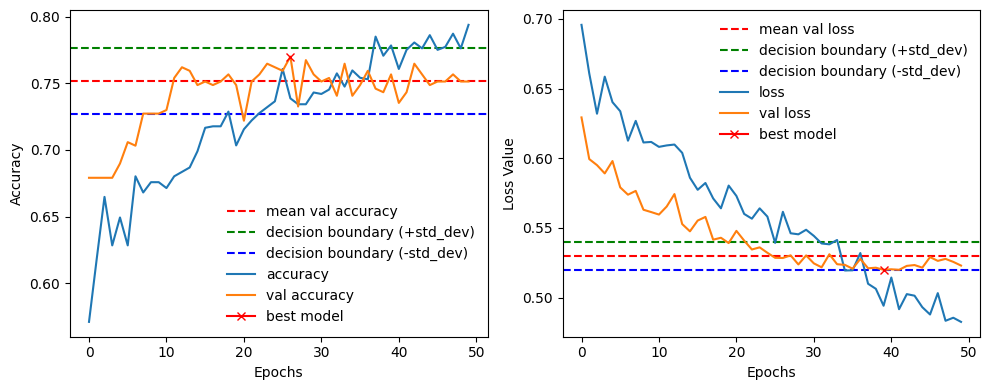

In [ ]:
#Plot the learning curves from the VGG16 model
import matplotlib.pyplot as plt
import numpy as np


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot for Loss Value

# Plotting
axes[1].axhline(VGG16_mean_loss, color='red', linestyle='--', label='mean val loss')
axes[1].axhline(VGG16_boundary_high_loss, color='green', linestyle='--', label='decision boundary (+std_dev)')
axes[1].axhline(VGG16_boundary_low_loss, color='blue', linestyle='--', label='decision boundary (-std_dev)')

axes[1].plot(VGG16.history["loss"], label="loss")
axes[1].plot(VGG16.history["val_loss"], label="val loss")
axes[1].plot(np.argmin(VGG16.history["val_loss"]),
             np.min(VGG16.history["val_loss"]),
             marker="x", color="r", label="best model")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss Value")
axes[1].legend(frameon=False)


# Plot for Validation Accuracy
axes[0].axhline(VGG16_mean_acc, color='red', linestyle='--', label='mean val accuracy')
axes[0].axhline(VGG16_boundary_high_acc, color='green', linestyle='--', label='decision boundary (+std_dev)')
axes[0].axhline(VGG16_boundary_low_acc, color='blue', linestyle='--', label='decision boundary (-std_dev)')
axes[0].plot(VGG16.history["accuracy"], label="accuracy")
axes[0].plot(VGG16.history["val_accuracy"], label="val accuracy")
axes[0].plot(np.argmax(VGG16.history["val_accuracy"]),
             np.max(VGG16.history["val_accuracy"]),
             marker="x", color="r", label="best model")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend(frameon=False)

plt.tight_layout()

plt.savefig("/content/drive/My Drive/Rays/Images_Graphs/Statistical/VGG16_50epochs_stats.png", dpi=300)

plt.show()
print()

#AlexNet

In [ ]:
#Create train & test data for the AlexNet and the LeNet
x_train = np.concatenate((c1_x_train, c2_x_train))
y_train = np.concatenate((c1_y_train, c2_y_train))
x_val = np.concatenate((c1_x_test, c2_x_test))
y_val = np.concatenate((c1_y_test, c2_y_test))

In [ ]:
#Define HyperParameters for AlexNet and LeNet
img_ch, img_width, img_height = 1, 224, 224
n_epochs = 50
batch_s = 3
n_base = 4
learn_rate = 1e-5

In [ ]:
#Instantiate the AlexNet model
alex = AlexNet(img_ch, img_width, img_height)

alex.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learn_rate),
              metrics=['binary_accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 4)       40        
                                                                 
 activation (Activation)     (None, 224, 224, 4)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 4)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 8)       296       
                                                                 
 activation_1 (Activation)   (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 8)        0         
 2D)                                                  

In [ ]:
#Train the AlexNet model
alex_hist = alex.fit(x_train, y_train, batch_size = batch_s,
                  validation_data = (x_val, y_val),
                  epochs = n_epochs, verbose=1)

Epoch 1/50
303/303 [==============================] - 41s 129ms/step - loss: 0.6817 - binary_accuracy: 0.6439 - val_loss: 0.6676 - val_binary_accuracy: 0.6791
Epoch 2/50
303/303 [==============================] - 36s 120ms/step - loss: 0.6551 - binary_accuracy: 0.6759 - val_loss: 0.6473 - val_binary_accuracy: 0.6791
Epoch 3/50
303/303 [==============================] - 41s 135ms/step - loss: 0.6450 - binary_accuracy: 0.6770 - val_loss: 0.6431 - val_binary_accuracy: 0.6791
Epoch 4/50
303/303 [==============================] - 36s 120ms/step - loss: 0.6411 - binary_accuracy: 0.6770 - val_loss: 0.6402 - val_binary_accuracy: 0.6791
Epoch 5/50
303/303 [==============================] - 40s 131ms/step - loss: 0.6387 - binary_accuracy: 0.6770 - val_loss: 0.6363 - val_binary_accuracy: 0.6791
Epoch 6/50
303/303 [==============================] - 38s 126ms/step - loss: 0.6318 - binary_accuracy: 0.6770 - val_loss: 0.6317 - val_binary_accuracy: 0.6791
Epoch 7/50
303/303 [==========================

In [ ]:
model_file_path = '/content/drive/My Drive/Rays/Projects/Saved_Models/AlexNet.h5'

# Save the model
alex.save(model_file_path)

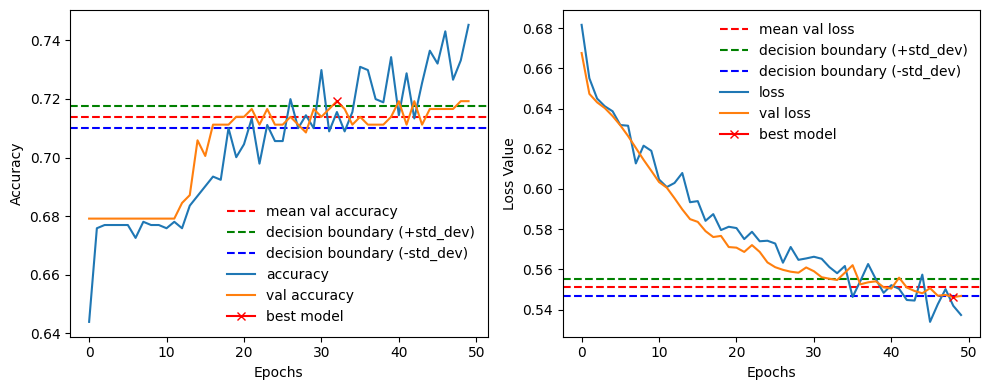

0.004068630107783256
0.003807470055277425
0.5510553479194641
0.7138273341315133


In [ ]:
#Plot the AlexNet learning curves
plotting(alex_hist, "/content/drive/My Drive/Rays/Images_Graphs/Statistical/AlexNET_50epochs_stats.png", False, 35, 15)

#LeNet

In [ ]:
#Instantiate the LeNet Model
lenet = LeNet(img_ch, img_width, img_height)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 4)       40        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 4)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 8)       296       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 8)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 8)                

In [ ]:
lenet.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learn_rate),
              metrics=['binary_accuracy'])

In [ ]:
#Train the LeNet model
lenet_hist = lenet.fit(x_train, y_train, batch_size = batch_s,
                  validation_data = (x_val, y_val),
                  epochs = n_epochs, verbose=1)

Epoch 1/50
303/303 [==============================] - 33s 106ms/step - loss: 0.6913 - binary_accuracy: 0.5733 - val_loss: 0.6844 - val_binary_accuracy: 0.6791
Epoch 2/50
303/303 [==============================] - 27s 89ms/step - loss: 0.6647 - binary_accuracy: 0.6770 - val_loss: 0.6470 - val_binary_accuracy: 0.6791
Epoch 3/50
303/303 [==============================] - 27s 88ms/step - loss: 0.6386 - binary_accuracy: 0.6770 - val_loss: 0.6338 - val_binary_accuracy: 0.6791
Epoch 4/50
303/303 [==============================] - 27s 89ms/step - loss: 0.6303 - binary_accuracy: 0.6770 - val_loss: 0.6295 - val_binary_accuracy: 0.6791
Epoch 5/50
303/303 [==============================] - 30s 99ms/step - loss: 0.6277 - binary_accuracy: 0.6770 - val_loss: 0.6278 - val_binary_accuracy: 0.6791
Epoch 6/50
303/303 [==============================] - 28s 92ms/step - loss: 0.6265 - binary_accuracy: 0.6770 - val_loss: 0.6267 - val_binary_accuracy: 0.6791
Epoch 7/50
303/303 [==============================]

In [ ]:
model_file_path = '/content/drive/My Drive/Rays/Projects/Saved_Models/LeNet.h5'

# Save the model
lenet.save(model_file_path)

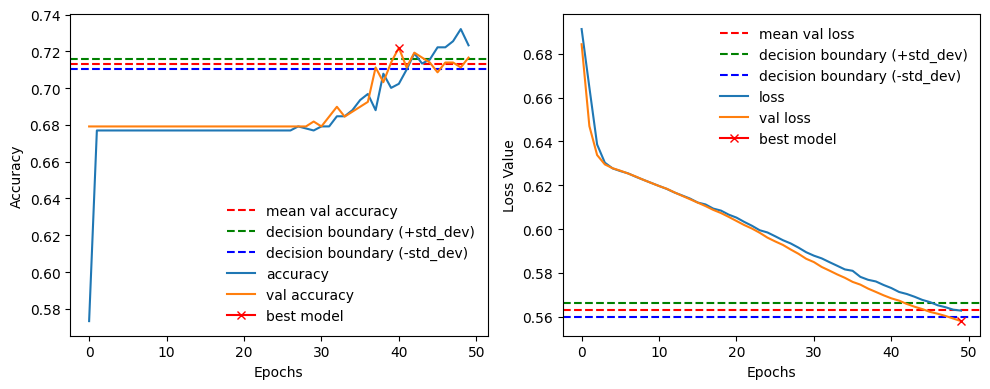

0.0032964087639748814
0.00272673782628227
0.5631074607372284
0.7128342151641845


In [ ]:
#Plot the LeNet learning curves
plotting(lenet_hist, "/content/drive/My Drive/Rays/Images_Graphs/Statistical/LeNET_50epochs_stats.png", False, 40,45)